# Práctica 2 - Curvas de luz de galaxias cercanas

## Carga de paquetes y definición de funciones

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
import astropy.constants as c
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS

from astropy.visualization import make_lupton_rgb, MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval, LogStretch, simple_norm
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

import tarfile
import os
import sys
import shutil

In [ ]:
#Aspecto de las figuras
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.labeltop'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"],'font.size': 18, 'axes.linewidth': 3})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'CMU Serif'
plt.rcParams['mathtext.it'] = 'CMU Serif:italic'
plt.rcParams['mathtext.bf'] = 'CMU Serif:bold'

plt.rc('legend',fontsize='small') # fuente de leyenda

In [ ]:
def plot_fotom(name, norm_percent, norm_power, anchura=False, center=False):
    #carga de datos  
    hdu = fits.open(name)[0] #carga imágen de referencia
    dat = hdu.data #la convierte en matriz de datos
    wcs = WCS(hdu); #carga coordenadas

    if anchura != False and center!=False: #si quiero solo ver parte de la imagen
        x,y = center[0], center[1]
        plot_data = dat[int(y)-anchura[0]:int(y)+anchura[0],int(x)-anchura[1]:int(x)+anchura[1]]
    else: #si la quiero ver entera
        plot_data = dat
    
    #plot
    norm = simple_norm(dat, percent=norm_percent ,stretch = 'power', power=norm_power) #estiro la imagen
    fig,ax = plt.subplots(figsize=[14,14]) #creo los ejes
    ax = plt.subplot(projection=wcs) #introduzco coordenadas

    ax.imshow(plot_data, origin='lower', norm=norm, cmap='afmhot') #dibujo los datos
    ax.grid(color='white', ls='dashed', alpha = 0.3) #rejilla
    ax.set_xlabel('Right Ascension (J2000)') #etiquetas de ejes
    ax.set_ylabel('Declinaction (J2000)')

In [ ]:
def fotom(file, center, r):
    """
    hace fotometría de apertura de SDSS
    file: directorio del archivo de entrada
    center: [...,...] coordenadas físicas del centro de la apertura
    r: valor en "(arcsec) del radio de la apertura
    """
    hdu = fits.open(file)[0] #carga imágen de referencia
    dat = hdu.data*u.nanomaggy #la convierte en matriz de datos
    wcs = WCS(hdu); #carga coordenadas 
    r_ap = r / 0.39616
    aperture = CircularAperture(center, r=r_ap) #creo apertura del tamaño en px escogido, pasandolo a "
    
    phot = aperture_photometry(dat, aperture, wcs=wcs)
    
    plot_fotom(file, norm_percent = 100-1e-1, norm_power = 0.9) #incluyo plot de galaxia
    ap_patches = aperture.plot(color='white', lw=2,label='Photometry aperture') #más la apertura calculada
    
    plt.ylim(center[1]-4*r, center[1]+4*r) #zoom para ver bien la apertura
    plt.xlim(center[0]-4*r, center[0]+4*r)
    
    return phot['aperture_sum']

## Motivación

El análisis fotométrico de galaxias es de gran utilidad para determinar parámetros como: el tamaño de la misma, derivar su morfología, la distribución de material, la presencia de regiones de formación estelar...

En este cuaderno vamos a estudiar:
- La magnitud total de la galaxia
- La curva de brillo superficial

Primero la dibujamos como ya sabemos (queremos imágen dónde sea vea núcleo + brazos):

In [ ]:
name = './M81_g.fits'
norm_percent = 100-5e-2
norm_power = 0.3

plot_fotom(name=name, norm_percent=norm_percent, norm_power=norm_power)

Ahora nos centramos en el núcleo (buscar coordenadas en DS9) con una anchura de [300,300]

Vemos claramente que el núcleo/bulbo es la parte más brillante de la galaxia. Nos centraremos en la parte interior de la misma. 

## Curva de brillo superficial

El brillo superficial se define como el flujo por ud. de área. Para ello vamos a definir una serie de aperturas de determinado radio, calcularemos el flujo integrado a toda su área y dividremos entre esta.

Las imágenes de SDSS están calibradas en una unidad denominada nanomaggies, las cuales se pueden relacionar con magnitudes comunes a través de $$ 1 \ nMgy = 3.631 \times 10^{-6} Jy$$
Para pasar a brillo superficial haremos $$ SB = flux/area =  F[Jy] / A["^2]$$ En las unidades estándar $[mag/"^2]$ (magnitudes por segundo de arco cuadrado) obtenemos $$ \mu [mag/"^2] = -2.5 \cdot \log_{10} \left( \frac{f_\nu [Jy]}{A["^2] \cdot 3631 Jy} \right)$$ Por lo que a paritr de las unidades de la imágen se obtiene que $$ \mu [mag/"^2] = -2.5 \cdot \log_{10} \left( \frac{f_\nu [nMgy] \cdot 3.631 \times 10^{-6} Jy}{A["^2] \cdot 3631 Jy} \right) = 22.5 -2.5 \cdot \log_{10} \left( \frac{f_\nu [nMgy]}{A["^2]} \right)$$ Lo que está de acuerdo con lo mostrado en http://www.sdss3.org/dr8/algorithms/magnitudes.php#nmgy

Primero exploramos la función de fotometría de apertura ya creada:

In [ ]:
help(fotom)

In [ ]:
name = './M81_g.fits'
center=[1029,420]
fotom(name, center, 25)

El ejemplo muestra el funcionamiento de la función fotom(), ahora queremos:
- `Cambiar unidades a las correctas dentro de la función para que devuelve brillo superficial correctamente`
- `Construir curva de brillo superficial de 1" a 200", con paso 1"`

Para ello tenemos que pasar de área en px^2 a "^2 obteniendo la relación entre los " que cubre cada px

In [ ]:
def fotom_sb(file, center, r, plot=True):
    hdu = fits.open(file)[0] #carga imágen de referencia
    dat = hdu.data*u.nanomaggy #la convierte en matriz de datos
    wcs = WCS(hdu); #carga coordenadas 
    aperture = CircularAperture(center, r=r) #creo apertura del tamaño en px escogido
    
    phot = aperture_photometry(dat, aperture, wcs=wcs)
    
    if plot == True:
        plot_fotom(file, norm_percent = 100-1e-2, norm_power = 0.9) #incluyo plot de galaxia
        ap_patches = aperture.plot(color='white', lw=2,label='Photometry aperture') #más la apertura calculada
        plt.ylim(center[1]-4*r, center[1]+4*r) #zoom para ver bien la apertura
        plt.xlim(center[0]-4*r, center[0]+4*r)
    
    area_px = aperture.area #área en px^2
    area = area_px * {!!!} * u.arcsec**2 #área en "^2
    arg = {!!!} * (u.arcsec**2 / u.nanomaggy) #argumento del logaritmo adimensionalizado
    sb = (22.5 - 2.5 * np.log10(arg.value)) * (u.mag * u.arcsec**(-2)) #para calcular magnitudes/"^2
    
    return sb

Probamos la función  anterior para ver su resultado, debería devolvernos 15.61 mag/arcsec^2

In [ ]:
name = './M81_g.fits'
center=[1029,420]
r = 1 / 0.39616      #valor de r en px dado r en arcsec
fotom_sb(name, center, r)

Construimos el bucle que calcula y almacena los resultados:

In [ ]:
r = np.arange(1,200) #creo vector de valores de r
sb = []              #inicializo vector vacío para acumular en el bucle
for px in r:         #recorro el vector y calculo valores de brillo superficial
    {!!!}

Para dibujar los resultados:

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot((r / 0.39616)**0.25, sb, '-o')
ax.invert_yaxis()

ax.set_ylabel(r'$\mu \ [mag/arcsec^2]$');
ax.set_xlabel(r'$r^{1/4} \ [arcsec^{1/4}]$');

Debería quedarnos algo del estilo si representamos en función de $r[arcsec]^{0.25}$:

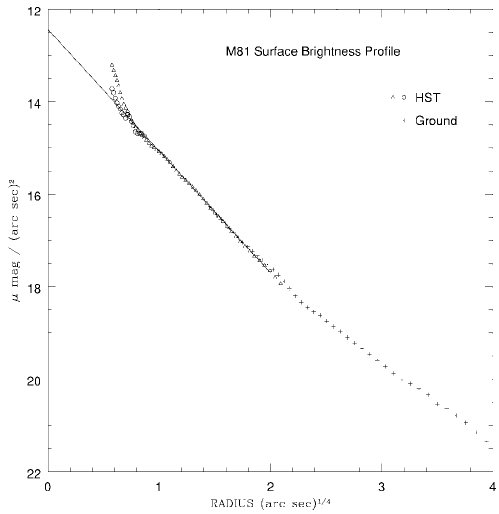

Sabemos que:
- Bulbos siguien una ley $\mu \propto -r^{1/4} $
- Discos siguen ley $\mu \propto -r$
Nosotros no vemos claramente la parte del bulbo, ya que no tenemos suficiente resolución en px

## Determianción de la magnitud total de una fuente

Ahora queremos derivar la magnitud integrada de una región en el cielo. En este caso queremos saber la de M101 (archivo `M101_g.fits`), en concreto de la región de los 12 " centrales de la misma. Comparar con el valor de bibliografía (en filtro g de SDSS/SLOAN).

Devuelve el resultado en nmgy, pero lo queremos pasar a magnitudes:

Si existe una desviación con respecto a los datos publicados en simbad, hay posibles explicaciones como:
- Falta de substración de señal de fondo
- Estrellas y contaminación intermedia
- Calibración burda de relación entre Jy y nmgy (como indican en http://www.sdss3.org/dr8/algorithms/magnitudes.php#nmgy)